In [1]:
from skimage.transform import pyramid_gaussian
import argparse
import cv2
import time
import numpy as np
import glob
from matplotlib import pyplot as plt

In [2]:
DEBUG = False
stop_sign = cv2.imread("../data/stop_sign.png")
stop_sign = cv2.resize(stop_sign, (16, 16))

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y:y+window_size[1], x:x+window_size[1]])
            
            

def meanSquareError(img1, img2):
    assert img1.shape == img2.shape, "Images must be the same shape."
    error = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    error = error/float(img1.shape[0] * img1.shape[1] * img1.shape[2])
    return error

def compareImages(img1, img2):
    return 1./meanSquareError(img1, img2)

def get_ssim(image, target, name, debug = False):
    start = time.time()
    max_ssim = -1
    max_img = None
    max_bbox = []  
    if image.shape[0] != 320 and image.shape[1] != 240:
        image = cv2.resize(image, (320, 240))
    
    while image.shape[0] > 16 and  image.shape[1] > 16:
        image = cv2.pyrDown(image)
        for (x, y, window) in sliding_window(image, step_size=2, window_size=(16, 16)):
            if window.shape[0] != 16 or window.shape[1] != 16:
                continue
            ssim = compareImages(stop_sign, image[y:y+16, x:x+16])
            if ssim > max_ssim:
                max_ssim = ssim
                max_img = image.copy()
                max_bbox = [(x, y), (x + 16, y + 16)] 
            if not debug:
                clone = image.copy()
                cv2.rectangle(clone, (x, y), (x + 16, y + 16), (255, 0, 0), 2)
                cv2.imshow("Window",clone)
                cv2.waitKey(1)
                time.sleep(0.025)
    if debug and max_ssim>-1:
        if max_ssim < 8e-5:
            cv2.rectangle(max_img, max_bbox[0], max_bbox[1], (0, 0, 255), 2)
        else:
            cv2.rectangle(max_img, max_bbox[0], max_bbox[1], (0, 255, 0), 2)
        cv2.imwrite("{}.png".format(name), max_img)
        cv2.destroyAllWindows()
    end = time.time()
    return max_ssim, end-start

In [3]:
stop_sign.shape == (16, 16, 3)

True

In [4]:
files = glob.glob('../data/stop_sign_data/')
exec_times = []
ssim = []
for file in files:
    img = cv2.imread(file)
    a, b = get_ssim(img, stop_sign, file.split('\\')[-1], debug=True)
    exec_times.append(b)
    ssim.append(a)

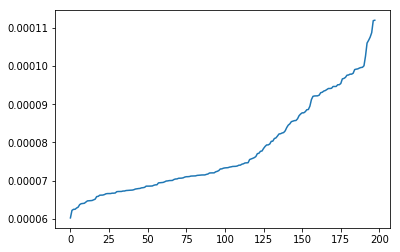

In [67]:
plt.plot(sorted(ssim))

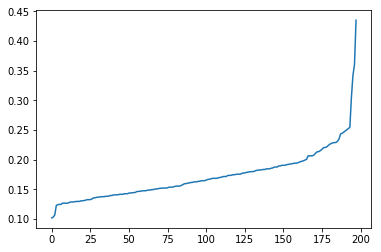

In [69]:
plt.plot(sorted(exec_times))